In [2]:
# Imports 
import sys
sys.path.append("..")
import os
os.environ["pyna_language"] = 'julia'
from julia.OpenMDAO import make_component
import julia.Main as julia
# from pyNA.src.noise_src.propagation import Propagation
import pdb
import numpy as np
import pandas as pd
import openmdao.api as om
import matplotlib.pyplot as plt
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)


In [13]:
# Create pyna_settings 
case = 'stca'
# case = 'a10'

if case == 'stca':
    # Directories and file names
    pyna_settings = pyna.load_settings('stca')
    pyna_settings.case_name = 'stca'                             # Case name [-]
    pyna_settings.engine_file_name = 'engine_stca.csv'           # File name of the take-off engine inputs [-] 
    pyna_settings.output_file_name = 'Trajectory_stca_epnl.sql'  # Name of the output .sql file [-]
    pyna_settings.ac_name = 'stca'                               # Name of the aircraft [-]

elif case == 'a10':
    # Directories and file names
    pyna_settings = pyna.load_settings('a10')
    pyna_settings.case_name = 'a10'                              # Case name [-]
    pyna_settings.case_directory = 'cases/a10'                   # Case directory [-]
    pyna_settings.engine_file_name = 'engine_a10.csv'            # File name of the take-off engine inputs [-] 
    pyna_settings.aero_file_name = 'aerodeck_flaps.xlsx'         # File name of the aerodynamics deck [-]
    pyna_settings.output_file_name = 'Trajectory_a10_epnl.sql'   # Name of the output .sql file [-]
    pyna_settings.ac_name = 'a10'                                # Name of the aircraft [-] ('stca')

# Save data
pyna_settings.save_results = True               # Flag to save results [-]

# Noise sources     
pyna_settings.fan_inlet = False                 # Enable fan inlet noise source (True/False)
pyna_settings.fan_discharge = False             # Enable fan discharge noise source (True/False)
pyna_settings.core = False                      # Enable core noise source (True/False)
pyna_settings.jet_mixing = False                # Enable jet mixing noise source (True/False)
pyna_settings.jet_shock =    False              # Enable jet shock noise source (True/False)
pyna_settings.airframe = False                  # Enable airframe noise source (True/False)
pyna_settings.all_sources = True                # Enable all noise sources (True/False)

# Modes
pyna_settings.method_core_turb = 'GE'           # Method to account for turbine transmission in the combustor ('GE', 'PW') [-]
pyna_settings.fan_BB_method = "geae"            # Method BB (original / allied_signal / geae / kresja) [-]
pyna_settings.fan_RS_method = "allied_signal"   # Method RS (original / allied_signal / geae / kresja) [-]
pyna_settings.fan_igv = False                   # Enable fan inlet guide vanes (True/False) 
pyna_settings.fan_id = False                    # Enable fan inlet distortions (True/False)
pyna_settings.ge_flight_cleanup = 'takeoff'     # GE flight cleanup switch (none/takeoff/approach) [-]
pyna_settings.levels_int_metric = 'epnl'        # Integrated noise metric [-]
pyna_settings.engine_mounting = 'none'          # Engine mounting ('fuselage'/'underwing'/'none') [-]

# Flags      
pyna_settings.absorption = True                 # Flag for atmospheric absorption
pyna_settings.groundeffects =  True             # Flag for ground effects
pyna_settings.lateral_attenuation = True        # Flag for empirical lateral attenuation effects
pyna_settings.suppression = True                # Flag for suppression of engine modules
pyna_settings.fan_liner_suppression = True      # Flag for fan liner suppression
pyna_settings.shielding = False                 # Flag for shielding effects (not implemented yet)
pyna_settings.hsr_calibration = True            # Flag for HSR-era airframe calibration
pyna_settings.validation = True                 # Flag for validation with NASA STCA noise model
pyna_settings.bandshare = False                 # Flag to plot PNLT
pyna_settings.TCF800 = True                     # Flag for tone penalty addition to PNLT metric; allows any tone below 800Hz to be ignored
pyna_settings.combination_tones = False         # Flag for combination tones int he fan noise model
pyna_settings.engine_mounting = 'none'          # Engine mounting ('fuselage'/'underwing'/'none') [-]

# Constants     
pyna_settings.N_shock = 8                       # Number of shocks in supersonic jet [-]
pyna_settings.dT = 10.0169                      # dT standard atmosphere [K]
pyna_settings.sigma = 291.0 * 515.379           # Specific flow resistance of ground [kg/s m3]
pyna_settings.a_coh = 0.01                      # Incoherence constant [-]
pyna_settings.N_f = 24                          # Number of discrete 1/3 octave frequency bands [-]
pyna_settings.N_b = 5                           # Number of bands (propagation) [-]
pyna_settings.n_altitude_absorption = 5         # Number of integration steps in atmospheric propagation [-]
pyna_settings.A_e = 10.334*(0.3048**2)          # Engine reference area [m2]
pyna_settings.dt_epnl = 0.5                     # Time step of to calculate EPNL from interpolated PNLT data [s]
pyna_settings.n_harmonics = 10                  # Number of harmonics to be considered in tones [-]
pyna_settings.r_0 = 0.3048                      # Distance source observer in source mode [m]
pyna_settings.p_ref = 2e-5                      # Reference pressure [Pa] 

pyna_settings.noise_optimization = False        # Flag to noise-optimize the trajectory [-]
pyna_settings.PTCB = False                      # Enable PTCB [-]
pyna_settings.PHLD = False                      # Enable PHLD [-]
pyna_settings.TS_to = 1.0                       # Engine TO thrust-setting (values < 1 denote APR) [-]
pyna_settings.TS_vnrs = 1.0                     # Engine VNRS thrust-setting [-]
pyna_settings.TS_cutback = None                 # Engine cutback thrust-setting [-]

pyna_settings.z_cutback = 25.                   # z-location of cutback [m]

pyna_settings.max_iter = 100                    # Maximum number of iterations for trajectory computations [-]

In [14]:
pyna_settings.N_f = 24
pyna_settings.TCF800 = False
pyna_settings.bandshare=True
py = pyna(pyna_settings)
x_obs = np.array([3780.46275, 450., 4*0.3048])

In [15]:
stca = py.load_results('../cases/NASA STCA Standard/output/Trajectory_stca.sql', 'final')
n_pp = np.where(stca.get_val('flyover.propagation.x') > 6500)[0][0]

### Levels

In [5]:
# Create problem
n_t = 1
prob_l = om.Problem()
comp = make_component(julia.Levels(n_t, py.settings, py.noise.data))
prob_l.model.add_subsystem("l", comp)
prob_l.setup(force_alloc_complex=False)

prob_l.set_val('l.rho_0', stca.get_val('flyover.levels.rho_0')[n_pp])
prob_l.set_val('l.c_0', stca.get_val('flyover.levels.c_0')[n_pp])
prob_l.set_val('l.msap_prop', stca.get_val('flyover.propagation.msap_prop')[n_pp,:])

prob_l.run_model()

In [6]:
dd_l = prob_l.compute_totals(of='l.pnlt', wrt='l.msap_prop', return_format='array')

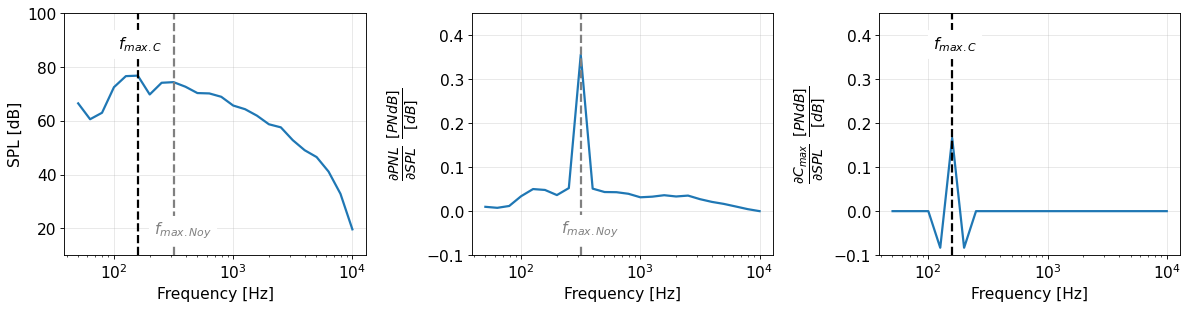

In [46]:
# Plot figure 
f_tone = py.noise.data.f[5]
f_tone2 = py.noise.data.f[8]

fig,ax = plt.subplots(1,3,figsize=(18,4))
plt.style.use('../post/plot.mplstyle')
ax[0].semilogx(py.noise.data.f, stca.get_val('flyover.levels.spl')[n_pp, :], '-')
ax[0].plot([f_tone, f_tone],[10, 100], 'k--')
ax[0].plot([f_tone2, f_tone2],[10, 100], '--', color='grey')
ax[0].set_ylim([10, 100])
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('SPL [dB]')
t = ax[0].annotate(xy=[f_tone2-100, 17.8], s='$f_{max. Noy}$', fontsize=14, color='grey')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))
t1 = ax[0].annotate(xy=[f_tone-50, 87], s='$f_{max. C}$', fontsize=14)
t1.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

# ax[0].annotate(xy=[f_tone2 + 100, ], s='$f_{max. Noy}$', fontsize=14, color='grey')


dpnldspl = np.array([ 0.00986425,  0.00757395,  0.01177654,  0.03405095,  0.05028744,
        0.04825603,  0.03659871,  0.05246523,  0.35616931,  0.05125511,
        0.04353029,  0.04312602,  0.03954451,  0.03155378,  0.03296236,
        0.03627357,  0.03340149,  0.03542225,  0.02730343,  0.02107783,
        0.01650591,  0.01061458,  0.00460099, -0.        ])
ax[1].semilogx(py.noise.data.f, dpnldspl, '-')
ax[1].set_ylim([-0.17, 0.4])
ax[1].plot([f_tone2, f_tone2],[-0.1, 0.45], '--', color='grey')
ax[1].set_ylim([-0.1, 0.45])
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel(r'$\frac{\partial PNL}{\partial SPL} \ \frac{[PNdB]}{[dB]}$', fontsize=18)

t = ax[1].annotate(xy=[f_tone2-100, -0.05], s='$f_{max. Noy}$', fontsize=14, color='grey')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax[2].semilogx(py.noise.data.f, dd_l.flatten()-dpnldspl, '-')
ax[2].set_ylim([-0.17, 0.4])
# ax[2].plot([400, 400],[-0.1, 0.45], 'k--')
ax[2].plot([f_tone, f_tone],[-0.1, 0.45], 'k--')
ax[2].set_ylim([-0.1, 0.45])
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel(r'$\frac{\partial C_{max}}{\partial SPL} \ \frac{[PNdB]}{[dB]}$', fontsize=18)
t1 = ax[2].annotate(xy=[f_tone-50, 0.37], s='$f_{max. C}$', fontsize=14)
t1.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

plt.subplots_adjust(wspace=0.35)

### Integrated levels

In [17]:
# Create problem
py.settings.bandshare=False
# py.settings.n_t = 210
py.settings.levels_int_metric='epnl'
prob_li = om.Problem()
comp = make_component(julia.LevelsInt(py.settings))
prob_li.model.add_subsystem("li", comp)
prob_li.setup(force_alloc_complex=False)

prob_li.set_val('li.t_o', stca.get_val('flyover.levels_int.t_o'))
prob_li.set_val('li.pnlt', stca.get_val('flyover.levels_int.pnlt'))

prob_li.run_model()

AttributeError: LevelsInt

In [10]:
dd_li = prob_li.compute_totals(of='li.epnl', wrt='li.pnlt', return_format='array')

In [11]:
# Compute max. PNLT point (k_m)
def compute_epnl_dod(t_o, pnlt):
    
    # Compute maximum pnlt
    pnltm = max(pnlt)
    I = np.where(pnlt > pnltm - 10.)

    # Compute integration bounds
    i_1 = I[0][0]
    if np.abs(pnlt[i_1] - (pnltm - 10)) > np.abs(pnlt[i_1 - 1] - (pnltm - 10)):
        i_1 = i_1 - 1

    i_2 = I[0][-1]
    if i_2 < pnlt.shape[0] - 1:
        if np.abs(pnlt[i_2] - (pnltm - 10)) > np.abs(pnlt[i_2 + 1] - (pnltm - 10)):
            i_2 = i_2 + 1
    
    return [t_o[i_1], t_o[i_2]]

In [1]:
# Plot figure 
dod = compute_epnl_dod(stca.get_val('flyover.geometry.t_o'), stca.get_val('flyover.levels.pnlt'))

fig,ax = plt.subplots(1,2,figsize=(18,4))
plt.style.use('../post/plot.mplstyle')
ax[0].plot(stca.get_val('flyover.geometry.t_o'), stca.get_val('flyover.levels.pnlt'), '-', label='NASA STCA Standard trajectory')
ax[0].fill_between([dod[0], dod[-1]], [0,0], [95,95], alpha=0.15, label='EPNL domain of dependence')
ax[0].set_xlabel('Time after brake release [s]')
ax[0].set_ylabel('PNLT [PNdB]')
ax[0].legend(fontsize=14, loc='lower left', bbox_to_anchor=(0.0, 1.01), ncol=1, borderaxespad=0, frameon=False)

ax[1].plot(stca.get_val('flyover.geometry.t_o'), dd_li.flatten(), '-o')
ax[1].fill_between([dod[0], dod[-1]], [-0.001,-0.001], [0.1,0.1], alpha=0.15)
ax[1].set_xlabel('Time after brake release [s]')
ax[1].set_ylabel(r'$\frac{\partial EPNL}{\partial PNLT} \ \frac{[EPNdB]}{[PNdB]}$', fontsize=18)

NameError: name 'compute_epnl_dod' is not defined